<a href="https://colab.research.google.com/github/ancestor9/2025_Winter_Deep-Learning-with-TensorFlow/blob/main/14_2_cnn_translation_invariance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **CNN의 핵심 설계 원리**

### 1. 국소 연결성 (Locality / Local Connectivity)
- 이미지의 모든 픽셀은 **주변 픽셀들과 밀접한 관련**이 있다는 가정에 기반
- **국부 수용장 (Receptive Field)**  
  - 시각 피질의 뉴런은 시야 전체가 아닌 **제한된 영역**에만 반응
- **공간적 특징 추출**  
  - CNN의 필터는 이미지의 **좁은 영역만 순차적으로 탐색**
  - 인접 픽셀 간의 **공간적 관계를 효과적으로 보존**

---

### 2. 가중치 공유 및 파라미터 효율성 (Weight Sharing & Parameter Efficiency)
- **특정 위치에서 유용한 특징은 다른 위치에서도 유용**하다는 가정
- **동일 필터 사용**
  - 왼쪽 상단에서 '가로선'을 검출하는 필터는
  - 오른쪽 하단에서도 동일하게 '가로선'을 검출
- **연산 및 학습 효율 향상**
  - 모든 위치마다 다른 뉴런을 두지 않고 **하나의 필터를 공유**
  - 학습해야 할 **파라미터 수가 크게 감소**
  - 모델이 가벼워지고 **과적합(Overfitting) 방지**

---

### 3. 계층적 특징 표현 (Hierarchical Feature Learning)
- **복잡한 사물은 단순한 형태의 조합**이라는 관점
- **단계적 특징 구축**
  - 하위 층: 선, 곡선 등 **단순 패턴** 감지
  - 상위 층: 하위 층 출력을 조합하여 **복잡한 패턴** 인식
- **추상화의 심화**
  - 층이 깊어질수록 인식 수준이 점진적으로 상승  
    - `점 / 선`  
    → `모양 / 질감`  
    → `사물의 부분`  
    → `전체 사물`

---

### 4. 이동 등변성 (Translation Equivariance)
- 이동 불변성(Translation Invariance)과는 구분되는 개념
- **위치 정보 유지**
  - 입력 이미지에서 객체가 오른쪽으로 2픽셀 이동하면
  - Feature Map에서도 **동일하게 2픽셀 이동**
- **정교한 위치 인식 가능**
  - 단순히 "사물이 있다"가 아니라
  - **사물이 어디에 있는지** 정확히 파악
- **주요 활용 분야**
  - 객체 탐지 (Object Detection)
  - 시맨틱 세그멘테이션 (Semantic Segmentation)


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

## **이동 등변성 (Translation Equivariance)**

In [ ]:
# 1. 5x5 크기의 아주 작은 이미지 생성 (가운데 점 하나: [1, 2] 위치)
img = torch.zeros((1, 1, 5, 5))
img[0, 0, 1, 2] = 1.0

# 2. 이미지를 오른쪽으로 1칸 밀기 (가운데 점 이동: [2, 2] -> [2, 4])
img_shifted = torch.zeros((1, 1, 5, 5))
img_shifted[0, 0, 4, 3] = 1.0

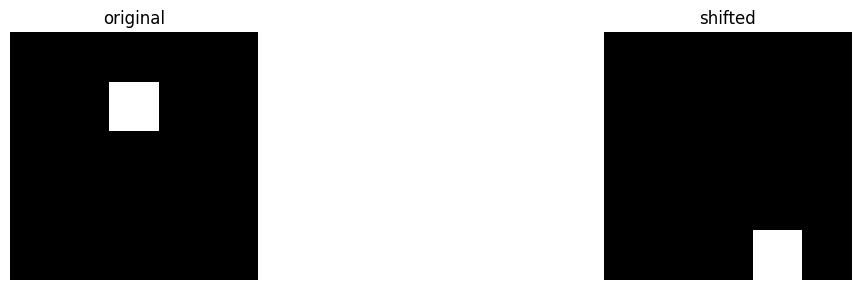

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

images = [(img, 'original'), (img_shifted, 'shifted'),]

for i, (img, title) in enumerate(images):
    axes[i].imshow(img.squeeze().cpu().numpy(), cmap='gray')
    axes[i].set_title(title)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# 3. 3x3 합성곱 층 정의 (특징을 잘 보기 위해 가중치를 1로 설정)
conv = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
conv.weight.data = torch.ones((1, 1, 3, 3))

# 4. 각각 연산 수행
output = conv(img)
output_shifted = conv(img_shifted)

# 5. 결과 출력 (가장 큰 값이 어디에 있는지 확인)
print("--- 원본 이미지 결과 (Output) ---")
print(output.squeeze()) # [1, 2] 근처가 활성화됨

print("\n--- 이동된 이미지 결과 (Output Shifted) ---")
print(output_shifted.squeeze()) # [2, 4] 근처가 활성화됨

--- 원본 이미지 결과 (Output) ---
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.]], grad_fn=<SqueezeBackward0>)

--- 이동된 이미지 결과 (Output Shifted) ---
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.]], grad_fn=<SqueezeBackward0>)


## **이동 불변성(Translation Invariance)**

In [ ]:
# --- 1. 이미지 준비 함수 ---
def create_image(position):
    # 10x10 검은색 배경 (배치와 채널 차원 추가: BxCxHxW = 1x1x10x10)
    img = torch.zeros((1, 1, 10, 10))

    # 3x3 흰색 사각형 그리기 (값 1)
    if position == 'top_left':
        img[0, 0, 0:3, 0:3] = 1
    elif position == 'center':
        img[0, 0, 3:6, 3:6] = 1
    elif position == 'bottom_right':
        img[0, 0, 7:10, 7:10] = 1
    return img

# 세 가지 이미지 생성
img_tl = create_image('top_left')
img_c = create_image('center')
img_br = create_image('bottom_right')

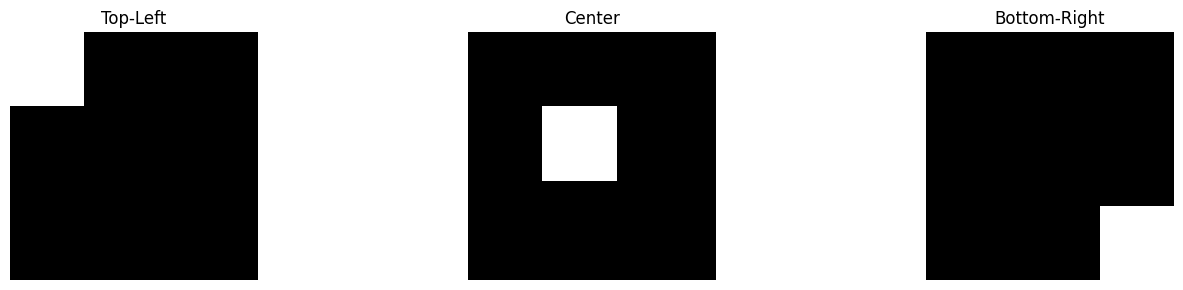

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

images = [(img_tl, 'Top-Left'), (img_c, 'Center'), (img_br, 'Bottom-Right')]

for i, (img, title) in enumerate(images):
    axes[i].imshow(img.squeeze().cpu().numpy(), cmap='gray')
    axes[i].set_title(title)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# --- 2. 모델 정의 (합성곱 + 맥스풀링) ---
# 3x3 필터를 사용하여 특징 추출
conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, bias=False)
# 필터 가중치를 모두 1로 강제 설정 (3x3 영역의 합을 계산하게 됨)
conv_layer.weight.data = torch.ones((1, 1, 3, 3))

# 2x2 맥스 풀링
pool_layer = nn.MaxPool2d(kernel_size=2, stride=2)


# --- 3. 실행 및 결과 확인 함수 ---
def process_and_print(img, title):
    print(f"--- {title} ---")

    # A. 합성곱 연산
    conv_out = conv_layer(img)
    # 결과에서 가장 높은 값과 그 위치 확인
    max_val = conv_out.max()
    max_idx = (conv_out == max_val).nonzero(as_tuple=False)
    print(f"[Conv 결과] 최대 활성값: {max_val.item()} (위치: {max_idx[0,2:]})")
    # 전체 맵을 보고 싶으면 주석 해제: print(conv_out.squeeze())

    # B. 맥스 풀링 연산
    pool_out = pool_layer(conv_out)
    max_val_pool = pool_out.max()
    max_idx_pool = (pool_out == max_val_pool).nonzero(as_tuple=False)
    print(f"[Pool 결과] 최대 활성값: {max_val_pool.item()} (위치: {max_idx_pool[0,2:]})")
    # 전체 맵을 보고 싶으면 주석 해제: print(pool_out.squeeze())
    print("\n")

# 실행
process_and_print(img_tl, "이미지 1: 왼쪽 상단")
process_and_print(img_c, "이미지 2: 중앙")
process_and_print(img_br, "이미지 3: 오른쪽 하단")

--- 이미지 1: 왼쪽 상단 ---
[Conv 결과] 최대 활성값: 9.0 (위치: tensor([0, 0]))
[Pool 결과] 최대 활성값: 9.0 (위치: tensor([0, 0]))


--- 이미지 2: 중앙 ---
[Conv 결과] 최대 활성값: 9.0 (위치: tensor([3, 3]))
[Pool 결과] 최대 활성값: 9.0 (위치: tensor([1, 1]))


--- 이미지 3: 오른쪽 하단 ---
[Conv 결과] 최대 활성값: 9.0 (위치: tensor([7, 7]))
[Pool 결과] 최대 활성값: 9.0 (위치: tensor([3, 3]))


